## Auger 2010 study

Use the model to fit the dataset first presented in Abreu et al. 2010 containing 69 events with energies E > 55 EeV. Recreate certain figures from Soiaporn et al.

The `arrival_direction` model is a stan implementation of the Soiaporn model with some changes to the parameterisation and priors. The `soiaporn_model` is true to the orginal implementation to allow meaningful comparison. 

In [1]:
import seaborn as sns
import corner
import numpy as np
import h5py

from analysis_interface import Data, Model, Analysis
from analysis_interface.detector.auger2010 import auger_location, theta_m, A, alpha_T, M, kappa_c

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


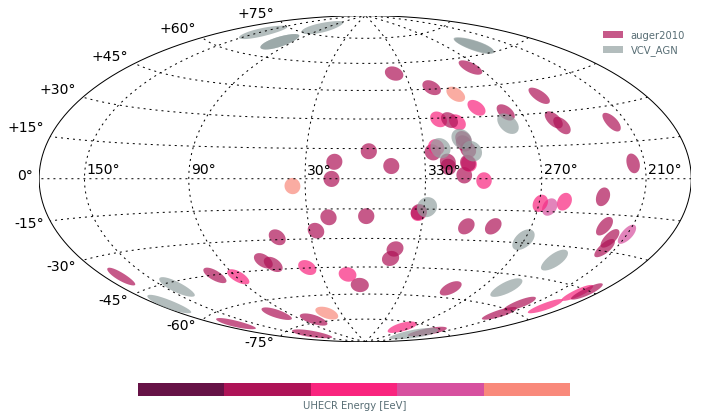

In [2]:
# read in relevant data
source_file = 'data/sourcedata.hdf5'
uhecr_file = 'data/UHECRdata.hdf5'

data = Data()
data.add_uhecr(uhecr_file, 'auger2010')
data.add_source(source_file, 'VCV_AGN')
data.add_detector(auger_location, theta_m, A, alpha_T, kappa_c, 'PAO')
data.show();

## Model for joint inference of $\kappa$

In [3]:
model_name = 'stan/soiaporn_model.stan'
sim_name = 'stan/arrival_direction_sim.stan'

model = Model(model_name, sim_name)
model.compile()

Using cached StanModel
Using cached StanModel


In [4]:
# create simulation to mimic data
Nsim = 100
F_T = Nsim * M / alpha_T
kappa = 100
f = 0.1
model.input(F_T, f, kappa)

print('F_T:', F_T)

F_T: 0.03633874963646063


In [5]:
# define analysis
simulation_file = 'data/recreateKS2012_simulation.hdf5'
with h5py.File(simulation_file, 'w') as file:
    desc = file.create_group('description')
    desc.attrs['summary'] = b'Testing out the recreation of KS2012 - simulation.'

analysis = Analysis(data, model, filename = simulation_file)

In [6]:
# simulate
analysis.build_tables(sim_only = True)
analysis.simulate(seed = 19920715)
analysis.save_simulation()

100 3280.5835077067964 0.00014895210816770477
100 2831.4495264659467 2.5154418297312908e-05
100 1041.0977569629272 5.060605793527628e-05
100 1766.2072761266968 4.250273874939337e-06
100 3130.5828230220513 0.0001666584407859135
100 3021.2066528828664 8.155406990933978e-05
100 2913.3705935328658 0.00010216578727915461
100 1081.5339309669716 5.7712939250470496e-05
100 1044.5651139444794 4.163701626204441e-05
100 0.11074689617926532 1.4737756269734222e-08
100 3189.9345175531735 0.00018569197698724282
100 8.21248911678273 1.1018382054667208e-07
100 3106.913832890444 7.66306695446561e-06
100 0.018194895004107335 1.435346244904408e-08
100 0.01729817367637326 1.4885355841478351e-08
100 3123.9318494724457 0.0001772935845997613
100 3288.821241674267 0.0001663252096204771

running stan simulation...
done
extracting output...
done
simulating zenith angles...
done
preparing fit inputs...
done


/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


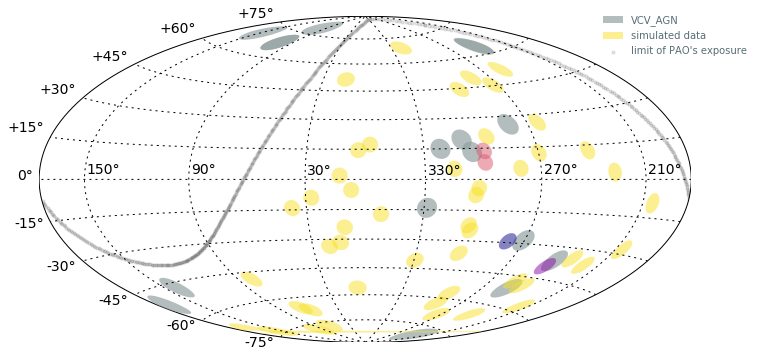

In [7]:
analysis.plot_simulation()

## Compare data and simulation

Quck test to see how simulated dataset performs.

In [21]:
# define analysis
output_file = 'data/recreateKS2012_comparison.hdf5'
with h5py.File(output_file, 'w') as file:
    desc = file.create_group('description')
    desc.attrs['summary'] = b'Testing out the recreation of KS2012 - comparing simulation with data.'

analysis = Analysis(data, model, filename = output_file)
analysis.use_simulation(simulation_file)

fit = analysis.fit_model(seed = 19920715)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


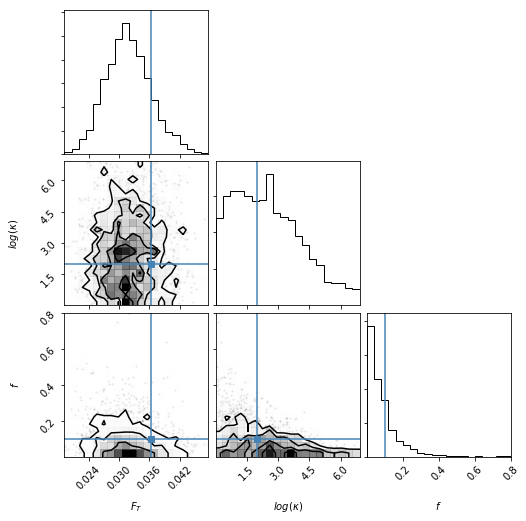

In [22]:
chain = fit.extract(permuted = True)
corner.corner(
    np.column_stack([chain[key] for key in ['F_T', 'log_kappa', 'f']]),
    labels=[r'$F_T$', r'$log(\kappa)$', r'$f$'],
    truths=[F_T, np.log10(kappa), f]);

In [23]:
# integral tables
table_file = 'data/integration_tables_50_VCV17_auger2010.hdf5'
analysis.use_tables(table_file)

# switch to data and compare
analysis.use_uhecr_data()
fit = analysis.fit_model(seed = 19920715)

preparing fit inputs...
done
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


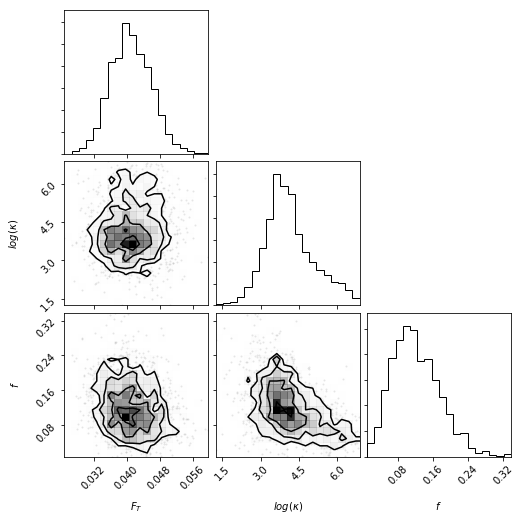

In [24]:
chain = fit.extract(permuted = True)
corner.corner(
    np.column_stack([chain[key] for key in ['F_T', 'log_kappa', 'f']]),
    labels=[r'$F_T$', r'$log(\kappa)$', r'$f$']);

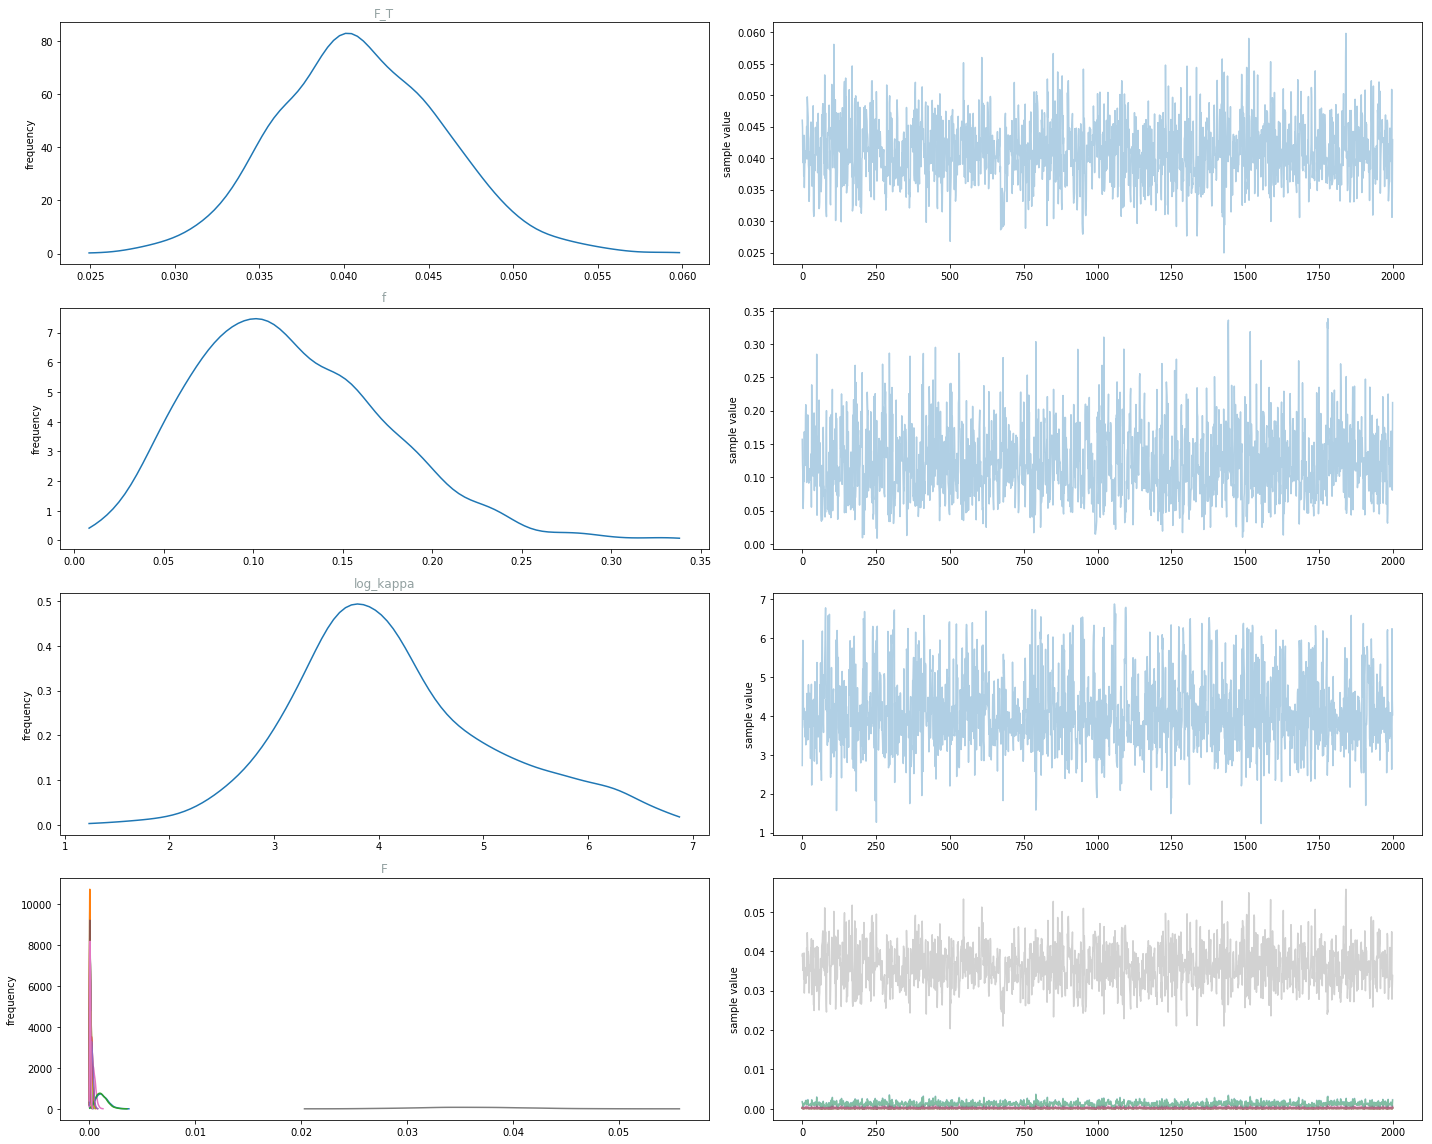

In [25]:
fig = fit.plot(['F_T', 'f', 'log_kappa', 'F']);
fig.set_size_inches(20, 16)
fig.tight_layout()

## Recreate Figure 5

Plot the marginal join posterior distributions for f and $\kappa$ for different periods. 

In [26]:
import pystan

In [27]:
# Fig 5, top right: all periods, 17 AGN
analysis.use_uhecr_data()

fit = analysis.fit_model(chains = 6, iterations = 20000, seed = 19920715)
chain = fit.extract(permuted = True)
samples = {'f' : chain['f'], 'log10_kappa' : np.log10(chain['kappa'])}

data_file = 'data/soiapornfig5a.data.R'
pystan.stan_rdump(samples, data_file)

preparing fit inputs...
done
0 of 60000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 60000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


In [28]:
#print(fit)

In [29]:
# Fig 5, top left:  periods 2 and 3, 17 AGN
analysis.data.uhecr.select_period([2, 3])
analysis.use_uhecr_data()

fit = analysis.fit_model(chains = 6, iterations = 20000, seed = 19920715)
chain = fit.extract(permuted = True)
samples = {'f' : chain['f'], 'log10_kappa' : np.log10(chain['kappa'])}
data_file = 'data/soiapornfig5b.data.R'
pystan.stan_rdump(samples, data_file)

preparing fit inputs...
done
0 of 60000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 60000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


In [30]:
#print(fit)

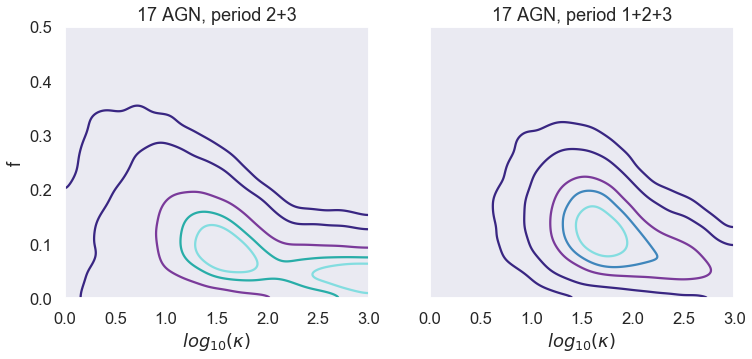

In [48]:
# make easy to compare plots
import vapeplot
from analysis_interface.plotting.soiaporn_plots import make_fig_5_plot
sns.set_style('dark')
sns.set_context('talk')
cmap = vapeplot.cmap('jazzcup')

chain_a = pystan.read_rdump('data/soiapornfig5a.data.R')
chain_b = pystan.read_rdump('data/soiapornfig5b.data.R')
levels = [0.25, 0.5, 0.75, 0.95, 0.99]

fig = make_fig_5_plot(chain_a, chain_b, levels, 15, cmap = cmap)
fig.savefig('tex/figures/soiaporn_fig5.png', facecolor='w', bbox_inches = 'tight')

## Recreate Figure 4

Plot the marginal posterior of f, conditioned on $\kappa$ = [10, 31.6, 100, 316, 1000]. To do this, need to use different stan model with kappa fixed.

In [35]:
from analysis_interface.interfaces import stan_utility
fixedkappa_model = stan_utility.compile_model('stan/soiaporn_model_fixedkappa.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c80c5216320746f1b28cac7bd0ec04b NOW.


In [40]:
# refresh data to have all AGN/periods
data = Data()
data.add_uhecr(uhecr_file, 'auger2010')
data.add_source(source_file, 'VCV_AGN')
data.add_detector(auger_location, theta_m, A, alpha_T, kappa_c, 'PAO')

# get interpolation table
with h5py.File(table_file, 'r') as f:
    eps = f['main/table'].value
    kappa_grid = f['main/kappa'].value
Ngrid = len(kappa_grid)

# scan over kappa
kappa = [10, 31.6, 100, 316, 1000]

In [41]:
# run 
f = []
for k in kappa:
    model_inputs = {'N_A' : data.source.N, 'varpi' : data.source.unit_vector, 
                    'D' : data.source.distance, 'N' : data.uhecr.N, 
                    'detected' : data.uhecr.unit_vector, 
                    'zenith_angle' : data.uhecr.incidence_angle, 'A' : data.uhecr.A,
                    'kappa_c' : kappa_c, 'alpha_T' : alpha_T, 'Ngrid' : Ngrid, 
                    'eps' : eps, 'kappa_grid' : kappa_grid, 'kappa' : k}
    
    fit = fixedkappa_model.sampling(data = model_inputs, iter = 5000, chains = 4, 
                                seed = 19920715)
    chain = fit.extract(permuted = True)
    f_samples = chain['f']
    f.append(f_samples)

In [42]:
# save
pystan.stan_rdump({'f' : f}, 'data/soiaporn_fig4.data.R')

In [43]:
# load
f = pystan.read_rdump('data/soiaporn_fig4.data.R')['f']

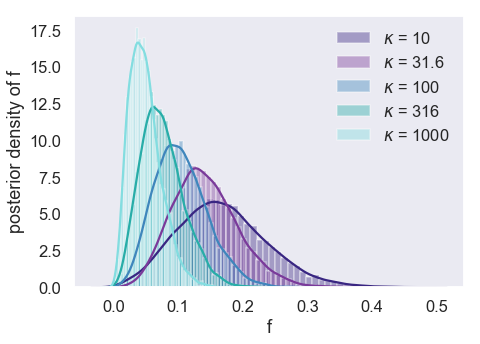

In [50]:
from matplotlib import pyplot as plt
vapeplot.set_palette('jazzcup')

i = 0
plt.figure(figsize = (7, 5))
for f_samples in f:
    sns.distplot(f_samples, label = '$\kappa$ = ' + str(kappa[i]))
    i += 1
plt.xlabel('f')
plt.ylabel('posterior density of f')
plt.legend(frameon = False)
plt.savefig('tex/figures/soiaporn_fig4.png', facecolor='w', bbox_inches = 'tight')